In [75]:
import networkx as nx 
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import operator
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, precision_score, recall_score, roc_auc_score
# DELTA_RECOVER = 7
# DELTA_INFECT = 5
# p_transmit_virus = .015
# SEED = .04

In [6]:
users = pd.read_csv('users_09_ground.csv')

In [8]:
users = users.set_index('author')
users

,subreddits,political_label,lib_inf_day,con_inf_day
author,,,,
---,"{'Android', 'AskReddit', 'answers', 'offmyches...",unaffiliated,2,2
---REDDIT---,"{'videos', 'politics', 'pics'}",unaffiliated,21,21
---ooo---,"{'Nootropics', 'lifehacks', 'funny'}",unaffiliated,31,31
---sniff---,"{'AskReddit', 'MLS', 'vba', 'Health', 'soccer'...",unaffiliated,31,31
--Audrey2,{'funny'},unaffiliated,31,31
...,...,...,...,...
zzziltoid,"{'AdviceAnimals', 'AskReddit'}",unaffiliated,13,13
zzzimcal,"{'Gore', 'exmormon', 'AskReddit', 'pics'}",unaffiliated,20,20
zzzonked33,"{'treemusic', 'AskReddit', 'funny', 'photoshop...",unaffiliated,26,26


In [19]:
#load networks
def build_networks(days):
    networks = list()
    for i in tqdm(range(days)):
        G = nx.read_gexf(f"./data/RC_2012-09_daily_graphs/{i+1}.gexf")
        networks.append(G)
    return networks

In [9]:
#This makes all 'conservative' and 'liberal' users 'infected' at the beginning.

def init_population():
    # infected = {
    #     'Liberal': set(),
    #     'Conservative': set(),
    # }
    for label in ['Conservative', 'Liberal']:
        for user in users.index:
            matches = users.at[user, 'political_label'] == label
            users.at[user, f'{label}_infected'] = matches
            users.at[user, f'{label}_day_infected'] = 1 if matches else 31
#             if matches:
#                 infected[label].add(person)
    
#     return infected

In [ ]:
init_population()
users

,subreddits,political_label,lib_inf_day,con_inf_day,Conservative_infected,Conservative_day_infected,Liberal_infected,Liberal_day_infected
author,,,,,,,,
---,"{'Android', 'AskReddit', 'answers', 'offmyches...",unaffiliated,2,2,False,31.0,False,31.0
---REDDIT---,"{'videos', 'politics', 'pics'}",unaffiliated,21,21,False,31.0,False,31.0
---ooo---,"{'Nootropics', 'lifehacks', 'funny'}",unaffiliated,31,31,False,31.0,False,31.0
---sniff---,"{'AskReddit', 'MLS', 'vba', 'Health', 'soccer'...",unaffiliated,31,31,False,31.0,False,31.0
--Audrey2,{'funny'},unaffiliated,31,31,False,31.0,False,31.0
...,...,...,...,...,...,...,...,...
zzziltoid,"{'AdviceAnimals', 'AskReddit'}",unaffiliated,13,13,False,31.0,False,31.0
zzzimcal,"{'Gore', 'exmormon', 'AskReddit', 'pics'}",unaffiliated,20,20,False,31.0,False,31.0
zzzonked33,"{'treemusic', 'AskReddit', 'funny', 'photoshop...",unaffiliated,26,26,False,31.0,False,31.0


In [127]:
#Susceptible-Infected simulation 
def run_experiment(days, networks, chance_param):
    for i in tqdm(range(days)):
        day = i + 1
        for label in ['Conservative', 'Liberal']:
            infected = set(users[users[f'{label}_infected']].index)
            G = networks[i]
            for user in infected:
                if user in G.nodes:
                    for _, neighbor, data in G.out_edges(user, data=True):
                        chance = chance_param * data['weight'] * data[f'avg_{label}_pol']
                        if random.random() <= chance:
                            users.at[neighbor, f'{label}_infected'] = True
                            users.at[neighbor, f'{label}_day_infected'] = day

In [130]:
# networks = build_networks(30)

In [140]:
init_population()
run_experiment(30, networks, 5000)

100%|█████████████████████████████████████████████████████████████| 30/30 [00:44<00:00,  1.49s/it]


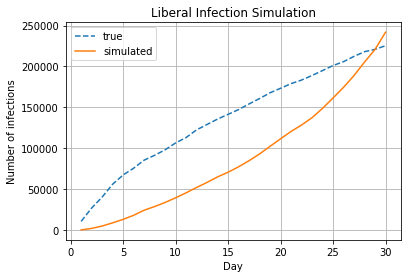

In [141]:
plot_SI(users)

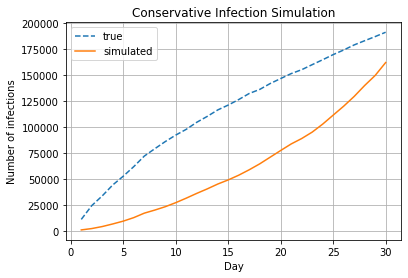

In [142]:
plot_SI(users, lib=False)

In [91]:
tuning_results = pd.DataFrame([1, 10, 100, 1000, 5000, 7500, 10000, 50000])
tuning_results = tuning_results.rename({0: 'coef'}, axis=1)
tuning_results = tuning_results.set_index('coef')

for chance_param in tuning_results.index:
    init_population()
    run_experiment(30, networks, chance_param)
    con_mse = mean_squared_error(users[f"con_inf_day"], users[f"Conservative_day_infected"])
    
    lib_mse = mean_squared_error(users[f"lib_inf_day"], users[f"Liberal_day_infected"])

    con_end_acc = ((users["con_inf_day"] != 31) == users["Conservative_infected"]).mean()
    lib_end_acc = ((users["lib_inf_day"] != 31) == users["Liberal_infected"]).mean()
    tuning_results.at[chance_param, f'Conservative MSE'] = con_mse
    tuning_results.at[chance_param, f'Conservative end state accuracy'] = con_end_acc
    tuning_results.at[chance_param, f'Conservative end state precision'] = precision_score(users[f"con_inf_day"] != 31, users[f"Conservative_infected"].astype(bool))
    tuning_results.at[chance_param, f'Conservative end state recall'] = recall_score(users[f"con_inf_day"] != 31, users[f"Conservative_infected"].astype(bool))
    tuning_results.at[chance_param, f'Conservative end state ROC-AUC'] = roc_auc_score(users[f"con_inf_day"] != 31, users[f"Conservative_infected"].astype(bool))
    tuning_results.at[chance_param, f'Liberal MSE'] = lib_mse
    tuning_results.at[chance_param, f'Liberal end state accuracy'] = lib_end_acc
    tuning_results.at[chance_param, f'Liberal end state precision'] = precision_score(users[f"lib_inf_day"] != 31, users[f"Liberal_infected"].astype(bool))
    tuning_results.at[chance_param, f'Liberal end state recall'] = recall_score(users[f"lib_inf_day"] != 31, users[f"Liberal_infected"].astype(bool))
    tuning_results.at[chance_param, f'Liberal end state ROC-AUC'] = roc_auc_score(users[f"lib_inf_day"] != 31, users[f"Liberal_infected"].astype(bool))

100%|█████████████████████████████████████████████████████████████| 30/30 [00:52<00:00,  1.74s/it]


In [110]:
def plot_tuning_result(tuning_results, name):
    plt.xlabel("Infection coefficient")
    plt.ylabel(name)
    plt.plot(tuning_results.index, tuning_results[name])
    plt.show()

In [123]:
tuning_results.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Conservative MSE,Conservative end state accuracy,Conservative end state precision,Conservative end state recall,Conservative end state ROC-AUC,Liberal MSE,Liberal end state accuracy,Liberal end state precision,Liberal end state recall,Liberal end state ROC-AUC
coef,,,,,,,,,,
1,191.837271,0.526403,0.998190,0.014444,0.507210,232.961333,0.433526,1.000000,0.001757,0.500878
10,191.664719,0.526858,0.981609,0.015660,0.507694,232.069056,0.435859,0.895871,0.006641,0.502814
100,189.859071,0.531669,0.892927,0.028836,0.512819,219.663719,0.469637,0.841299,0.080596,0.530325
1000,171.895172,0.588188,0.778408,0.199905,0.573632,178.489204,0.623101,0.738536,0.519882,0.639203
5000,157.210449,0.651243,0.661623,0.561269,0.647870,183.731056,0.618834,0.652887,0.701003,0.606016
7500,160.280444,0.642504,0.625612,0.637582,0.642320,184.731283,0.616115,0.647320,0.710763,0.601351
10000,163.704715,0.631414,0.604078,0.676043,0.633087,184.731283,0.616115,0.647320,0.710763,0.601351
50000,172.866273,0.599615,0.563644,0.738504,0.604822,184.731283,0.616115,0.647320,0.710763,0.601351


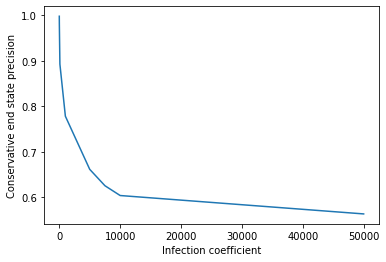

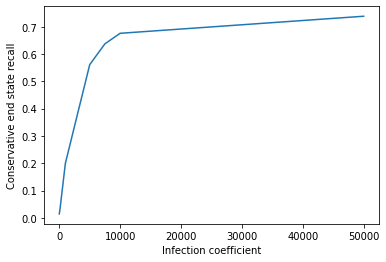

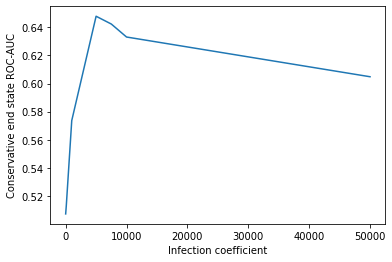

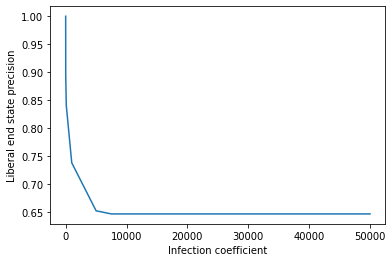

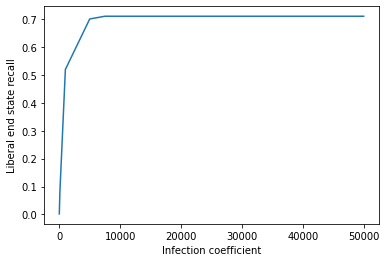

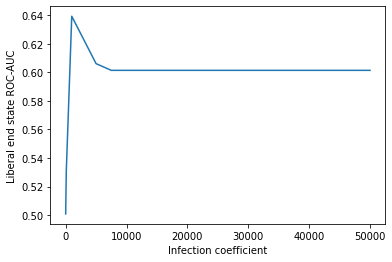

In [114]:
plot_tuning_result(tuning_results, f'Conservative end state precision')
plot_tuning_result(tuning_results, f'Conservative end state recall')
plot_tuning_result(tuning_results, f'Conservative end state ROC-AUC')
plot_tuning_result(tuning_results, f'Liberal end state precision')
plot_tuning_result(tuning_results, f'Liberal end state recall')
plot_tuning_result(tuning_results, f'Liberal end state ROC-AUC')

In [74]:
def plot_SI(users):
    plt.figure()
    plt.plot([x for x in range(days-1)], [len([y[0] for y in networks[x].nodes.data() if y[1]['status'] == 'infected']) for x in range(days-1)], label='infected')
    plt.legend()
    plt.grid()
    plt.title("Number of Infections vs Day")
    plt.xlabel("Day")
    plt.ylabel("Number of infections")
    plt.show()    
    return 

In [99]:
def infected_on_day(users, day, label, short_l, true_count=True):
    if true_count:
        return len(users[users[f'{short_l}_inf_day'] <= day].index)
    else:
        return len(users[users[f'{label}_day_infected'] <= day].index)

def infected_count(users, days, lib=True):
    label = 'Liberal' if lib else 'Conservative'
    short_l = 'lib' if lib else 'con'
    return (
        [infected_on_day(users, day, label, short_l) for day in days],
        [infected_on_day(users, day, label, short_l, true_count=False) for day in days],
    )
    

In [106]:
def plot_SI(users, lib=True):
    label = 'Liberal' if lib else 'Conservative'
    days = list(range(1, 31))
    true, pred = infected_count(users, days, lib)
    plt.plot(days, true, '--', label='true')
    plt.plot(days, pred, label='simulated')
    plt.legend()
    plt.grid()
    plt.title(f"{label} Infection Simulation")
    plt.xlabel("Day")
    plt.ylabel("Number of infections")
    plt.show()    
    return 

In [109]:
len(users.index)

397213